In [574]:
from glob import glob
import pandas as pd
import numpy as np
import os

import keras
from keras import layers,models
from keras.preprocessing.sequence import pad_sequences
from keras.layers.core import Activation
from keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

In [514]:
x=0
for filename in glob("UCRArchive_2018/*"):
    train_name = os.path.join(filename,os.path.basename(filename)+"_TRAIN.tsv")
    test_name = os.path.join(filename,os.path.basename(filename)+"_TEST.tsv")
    if x%19==0:
        break
    x+=1

In [515]:
df_train=pd.read_table(train_name,header=None)
y_train=df_train.values[:,0]
X_train=df_train.values[:,1:]

df_test=pd.read_table(test_name,header=None)
y_test=df_test.values[:,0]
X_test=df_test.values[:,1:]

ss=StandardScaler()
X_train=ss.fit_transform(X_train)
X_test=ss.transform(X_test)


r=8

if not X_train.shape[-1] %r==0:
    X_train = pad_sequences(X_train,X_train.shape[-1] //r *r+r,dtype=float)
    X_test = pad_sequences(X_test,X_test.shape[-1] //r *r+r,dtype=float)

In [516]:
import matplotlib.pyplot as plt

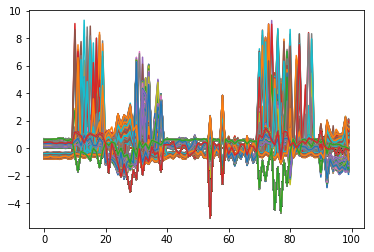

In [517]:
plt.plot(X_train)
plt.show()

In [565]:
input_dim = X_train.shape[-1]
inputs=layers.Input([input_dim])
x=layers.Reshape([input_dim,1])(inputs)

x=layers.SeparableConv1D(64,16,padding="same")(x)
x=layers.SeparableConv1D(48,8,padding="same")(x)
x=layers.MaxPooling1D(2)(x)
x=layers.normalization.BatchNormalization()(x)
x=Activation("relu")(x)

x=layers.SeparableConv1D(32,4,padding="same")(x)
x=layers.SeparableConv1D(16,4,padding="same")(x)
x=layers.MaxPooling1D(2)(x)
x=layers.normalization.BatchNormalization()(x)
hidden = layers.Flatten()(x)
x=Activation("relu")(x)
"""
s = x.shape
x = layers.Flatten()(x)

x = layers.Dense(int(input_dim/4))(x)
hidden = x
x = layers.Dense(s.as_list()[1]*s.as_list()[2],trainable=False)(x)
x = layers.Reshape([s.as_list()[1],s.as_list()[2]])(x)
"""

x=layers.UpSampling1D(2)(x)
x=layers.SeparableConv1D(16,4,padding="same")(x)
x=layers.SeparableConv1D(32,4,padding="same")(x)
x=layers.normalization.BatchNormalization()(x)
x=Activation("relu")(x)

x=layers.UpSampling1D(2)(x)
x=layers.SeparableConv1D(48,8,padding="same")(x)
x=layers.SeparableConv1D(64,16,padding="same")(x)
x=layers.normalization.BatchNormalization()(x)
x=Activation("relu")(x)


x=layers.Dense(1)(x)
x=layers.Reshape([input_dim])(x)
encoder = models.Model(inputs,hidden)
model = models.Model(inputs,x)
model.compile("adam","mse")

In [566]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_94 (InputLayer)        (None, 1464)              0         
_________________________________________________________________
reshape_162 (Reshape)        (None, 1464, 1)           0         
_________________________________________________________________
separable_conv1d_365 (Separa (None, 1464, 64)          144       
_________________________________________________________________
separable_conv1d_366 (Separa (None, 1464, 48)          3632      
_________________________________________________________________
max_pooling1d_151 (MaxPoolin (None, 732, 48)           0         
_________________________________________________________________
batch_normalization_191 (Bat (None, 732, 48)           192       
_________________________________________________________________
activation_249 (Activation)  (None, 732, 48)           0         
__________

In [567]:
model.fit(X_train,X_train,epochs=100)

Epoch 1/100
100/100 [==============================] - 13s 134ms/step - loss: 1.0077
Epoch 2/100
100/100 [==============================] - 0s 2ms/step - loss: 0.9304
Epoch 3/100
100/100 [==============================] - 0s 2ms/step - loss: 0.8537
Epoch 4/100
100/100 [==============================] - 0s 2ms/step - loss: 0.8426
Epoch 5/100
100/100 [==============================] - 0s 2ms/step - loss: 0.8147
Epoch 6/100
100/100 [==============================] - 0s 2ms/step - loss: 0.8047
Epoch 7/100
100/100 [==============================] - 0s 2ms/step - loss: 0.7850
Epoch 8/100
100/100 [==============================] - 0s 2ms/step - loss: 0.7739
Epoch 9/100
100/100 [==============================] - 0s 2ms/step - loss: 0.7517
Epoch 10/100
100/100 [==============================] - 0s 2ms/step - loss: 0.7292
Epoch 11/100
100/100 [==============================] - 0s 2ms/step - loss: 0.7190
Epoch 12/100
100/100 [==============================] - 0s 2ms/step - loss: 0.6912
Epoch 13/1

Epoch 99/100
100/100 [==============================] - ETA: 0s - loss: 0.146 - 0s 2ms/step - loss: 0.1447
Epoch 100/100
100/100 [==============================] - 0s 2ms/step - loss: 0.1402


In [586]:
clf=RandomForestClassifier(n_estimators=10)
clf.fit(encoder.predict(X_train),y_train)
clf.score(encoder.predict(X_test),y_test)

0.75

In [587]:
clf=RandomForestClassifier(n_estimators=10)
clf.fit(X_train,y_train)
clf.score(X_test,y_test)

0.77